In [9]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from pathlib import Path
import cv2
import os
import warnings
import pandas as pd
from collections import deque


In [10]:
# hyperparameters
batch_size = 32
lr = 0.0001
imgSize = 150
epochs = 10
numTrainSamples = 1000  # Change later on
numValSamples = 100  # Change later on

In [11]:
data_dir = Path("./chest_xray_corrected/")
train = data_dir / "train"
val = data_dir / "val"
test = data_dir / "test"

normal = train / "NORMAL"
pneumonia = train / "PNEUMONIA"


# normalFreq = sum(1 for _ in normal.glob("*.jpeg"))
# pneumoniaFreq = sum(1 for _ in pneumonia.glob("*.jpeg"))

# numTrainSamples = normalFreq + pneumoniaFreq


# labels = pd.Series([*[0]*normalFreq, *[1]*pneumoniaFreq])

# sns.set()
# fig, ax = plt.subplots(1, figsize=(10,6))
# vc = labels.value_counts(normalize=True)
# # labels
# count = sns.countplot(x=labels, edgecolor="black", ax=ax)
# count.set_title("Label Distribution(After generation)")

# plt.savefig("output.jpg")

In [12]:

# Creating an ImageGenerator

data_gen = ImageDataGenerator(rescale=1./255,   # Rescale from 0-255 to 0-1
                                   rotation_range=30,  # rondomly rotate training iamges by 30
                                   width_shift_range=0.1,  # randomly shift images horizontally by 10% of width
                                   height_shift_range=0.1,   # randomly shift images horizontally by 10% of height
                                   zoom_range=0.2,  # Randomly zoom in/out 20% into image
                                   horizontal_flip=True)  # Randomly flip image horizontally


test_datagen = ImageDataGenerator(rescale=1./255)

training_gen = data_gen.flow_from_directory(train, target_size=(imgSize, imgSize), batch_size=batch_size, class_mode="binary")
validation_gen = data_gen.flow_from_directory(val, target_size=(imgSize, imgSize), batch_size=batch_size, class_mode="binary")

# # Visualizing the outputs of the generators

# fig, axs = plt.subplots(1,4, figsize=(10,3))
# fig.suptitle("Generated Training Images")
# generated = next(training_gen)
# images = generated[0]
# for i, ax in enumerate(axs):
#     ax.imshow(images[i])
#     ax.axis('off')
    
    
    


Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


0    0.38125
1    0.61875
dtype: float64

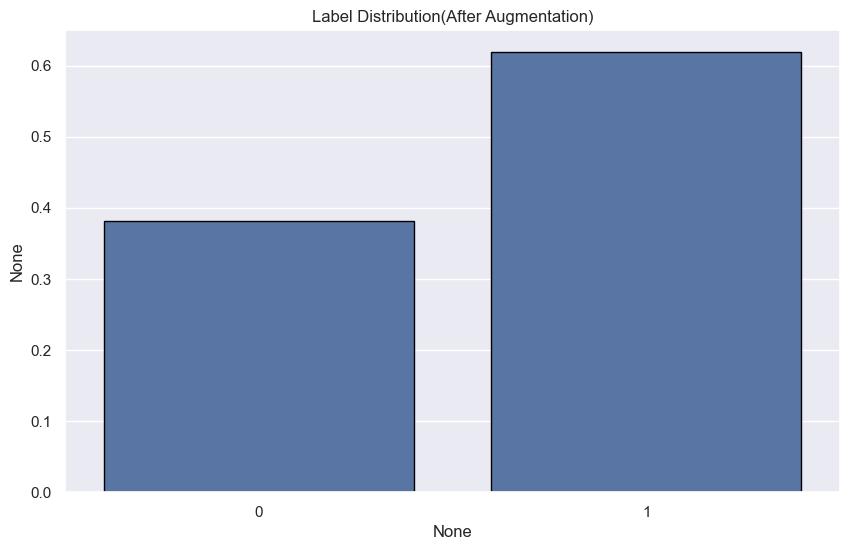

In [13]:



total = pd.Series([0,0])

for i in range(5):
    generated = next(training_gen)
    labels = np.array(generated[1]).astype(int) 
    total += np.array(pd.Series(labels).value_counts(normalize=True, sort=False).sort_values())
    
total /= 5
sns.set()
fig, ax = plt.subplots(1, figsize=(10,6))
count = sns.barplot(x=total.index, y=total, edgecolor = "black", ax=ax)
count.set_title("Label Distribution(After Augmentation)")
plt.savefig("output-after-augmentation.jpg")
total

In [14]:
# Very simple model



# class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(imgSize, imgSize, 3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer = "adam" , loss =tf.losses.BinaryCrossentropy(from_logits=False) , metrics = ['accuracy'])

In [16]:
model.fit(training_gen, validation_data=validation_gen,epochs=5, batch_size=batch_size)

Epoch 1/5
20/20 [==============================] - 36s 2s/step - loss: 0.6614 - accuracy: 0.6282 - val_loss: 0.6651 - val_accuracy: 0.8019
Epoch 2/5
20/20 [==============================] - 37s 2s/step - loss: 0.6576 - accuracy: 0.6394 - val_loss: 0.5855 - val_accuracy: 0.7692
Epoch 3/5
20/20 [==============================] - 37s 2s/step - loss: 0.6134 - accuracy: 0.6731 - val_loss: 0.5267 - val_accuracy: 0.8212
Epoch 4/5
20/20 [==============================] - 38s 2s/step - loss: 0.5572 - accuracy: 0.7372 - val_loss: 0.5880 - val_accuracy: 0.6471
Epoch 5/5
20/20 [==============================] - 37s 2s/step - loss: 0.5515 - accuracy: 0.7388 - val_loss: 0.3925 - val_accuracy: 0.8394


In [ ]:
model.evaluate_generator(test_datagen)

C:\Users\PC\AppData\Local\Temp\ipykernel_15044\3205061440.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_datagen)


ValueError: Failed to find data adapter that can handle input: <class 'keras.src.preprocessing.image.ImageDataGenerator'>, <class 'NoneType'>